In [1]:
import numpy as np
import pandas as pd
import pywt

import matplotlib.pyplot as plt

In [2]:
import filter_utils as filt
import basis_pursiut_denoising as bpdn

In [3]:
data_dir = "./data/"
data_fn = data_dir + "cleaned_data.txt"
data_grey_fn = data_dir + "cleaned_grey_values.txt"

In [4]:
all_elements = pd.read_csv(data_fn)
print(all_elements.head())

   Distance (um)  Elapsed Time   B11_ppm  Na23_ppm  Mg25_ppm  Al27_ppm  \
0      -1.483983     -1.483983 -0.000987 -1.739987  1.252779 -1.428722   
1      -1.478071     -1.478071  0.273978 -0.963147  2.358353 -1.189735   
2      -1.472164     -1.472164 -0.041514 -1.274842  1.587131 -0.879393   
3      -1.466252     -1.466252  0.646814 -0.961113  1.437627 -1.582681   
4      -1.460344     -1.460344  0.151465 -1.214546  1.474992 -1.570397   

   Si28_ppm   P31_ppm   S34_ppm  Cl35_ppm  ...  Zn66_ppm  Zn68_ppm  Sr88_ppm  \
0 -1.030042  1.095407  0.576121 -1.078462  ...  1.409131  1.572304  1.231484   
1 -0.483173  1.588047  1.585102 -1.104329  ...  1.439062  1.372410  0.979279   
2 -0.694485  1.389658  0.317097 -0.880657  ...  1.674240  1.736563  0.941318   
3 -1.052700  1.525399 -0.236500 -1.136729  ...  1.628649  1.488895 -0.189878   
4 -1.296695  1.237596 -0.067184 -1.486543  ...  1.335298  1.297910  0.958900   

   Ba138_ppm  PbTotal_ppm     pixel  new_distance  new_pixel  case  sex  


In [5]:
grey_values = pd.read_csv(data_grey_fn)
print(grey_values)

      Distance_(pixels)  Gray_Value  new_pixel  case  cleaned_grey sex
0                   432    126.7965          0    43      4.842583   M
1                   433    126.2878          1    43      4.838563   M
2                   434    123.3846          2    43      4.815306   M
3                   435    120.0393          3    43      4.787819   M
4                   436    118.5882          4    43      4.775657   M
...                 ...         ...        ...   ...           ...  ..
5678               1746    104.8251       1480    56      4.631919   F
5679               1747    104.6929       1481    56      4.631425   F
5680               1748    103.3024       1482    56      4.637661   F
5681               1749    101.6086       1483    56      4.621128   F
5682               1750    101.0000       1484    56      4.615121   F

[5683 rows x 6 columns]


In [6]:
elt_name = "Sr88_ppm" # "Cu65_ppm" # "Zn66_ppm" # "Mg25_ppm" # "S34_ppm" # 
elt_array = [
    all_elements[all_elements['case']==i][elt_name] for i in [43,44,55,56]
]
print([len(arr) for arr in elt_array])

[461, 320, 570, 711]


i=1, px=0.1500000111532847
i=2, px=0.127500009480292
i=3, px=0.10837500805824818
i=4, px=0.09211875684951096
i=5, px=0.07830094332208432
i=6, px=0.06655580182377167
i=7, px=0.056572431550205915
i=8, px=0.04808656681767502
i=9, px=0.040873581795023775
i=10, px=0.034742544525770205
i=11, px=0.02953116284690467
i=12, px=0.025101488419868968
i=13, px=0.021336265156888624
i=14, px=0.01813582538335533
i=15, px=0.01541545157585203
i=16, px=0.013103133839474226
i=17, px=0.011137663763553091
i=18, px=0.009467014199020128
i=19, px=0.008046962069167109
i=20, px=0.006839917758792042
i=21, px=0.005813930094973235
i=22, px=0.00494184058072725
i=23, px=0.004200564493618162
i=24, px=0.003570479819575438
i=25, px=0.003034907846639122
i=26, px=0.002579671669643254
i=27, px=0.002192720919196766
i=28, px=0.0018638127813172508
i=29, px=0.0015842408641196632
i=30, px=0.0013466047345017137
i=31, px=0.0011446140243264566
i=32, px=0.0009729219206774881
i=33, px=0.0008269836325758648
i=34, px=0.0007029360876894

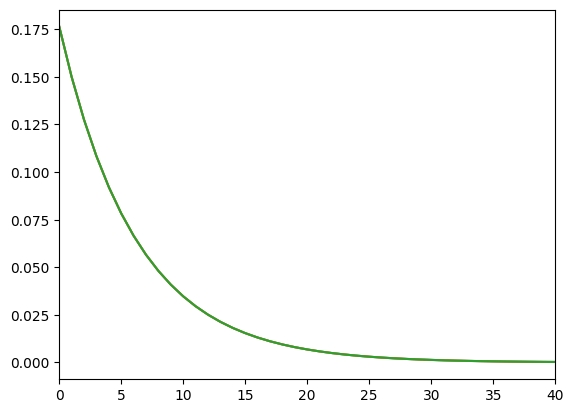

In [7]:
bandwidth = 100
mortality_rate = 0.15

def truncated_geometric_pdf(p: float, k: int, n: int = bandwidth) -> float:
    if k < 0 or n < 0:
        return 0.0
    return p * (1 - p)**(k-1) / (1 - (1 - p)**(n+1))

def prior1(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Find the idx of the max True element.
    # This is the index of the highest frequency basis function included.
    # This is a proxy for age since age is the number of peaks and the 
    # highest frequency basis function has the most peaks of all basis functions.
    # (This is not a perfect proxy since a combination of lower frequency
    # basis functions can produce more peaks than a single high frequency)
    idx = -1
    for i in range(len(x)-1, -1, -1):
        if x[i]:
            idx = i
            break
    return truncated_geometric_pdf(p, i)

def prior2(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Sum the frequencies of all basis functions.
    # This is a proxy for age since age is the number of peaks which is
    # at most the sum of all frequencies.
    s = 0
    for i in range(len(x)):
        s += i * x[i]
    return truncated_geometric_pdf(p, s)

# Assume that the mortality rate is 20% per year => p=0.8, prior prob of age s is 0.8^s.
def prior(x= np.ndarray, p=mortality_rate, q=0.9) -> np.ndarray:
    return prior1(x,p)*q + prior2(x,p)*(1-q)

xi = range(0, bandwidth+1)
xv = np.eye(bandwidth+1)
p1x = [prior1(xv[i]) for i in range(len(xv))]
p2x = [prior2(xv[i]) for i in range(len(xv))]
px = [prior(xv[i]) for i in range(len(xv))]
for i in range(1, len(px)):
    print(f"i={i}, px={px[i]}")
p = plt.figure()
p = plt.plot(xi, p1x, label="prior1")
p = plt.plot(xi, p2x, label="prior2")
p = plt.plot(xi, px, label="prior")
p = plt.xlim(0,40)
p = plt.show()

In [8]:
# threshold = filt.SUBSTANTIAL_DIFFERENCE_IN_MODELS_THRESHOLD # Substantial difference between models required to pick the more complex one.
threshold = filt.SIGNIFICANT_DIFFERENCE_IN_MODELS_THRESHOLD # Strong difference between models required to pick the more complex one.

In [9]:
criterion = "bic" # "aic" or "bic"
mode = "forward" # "forward" or "backward"

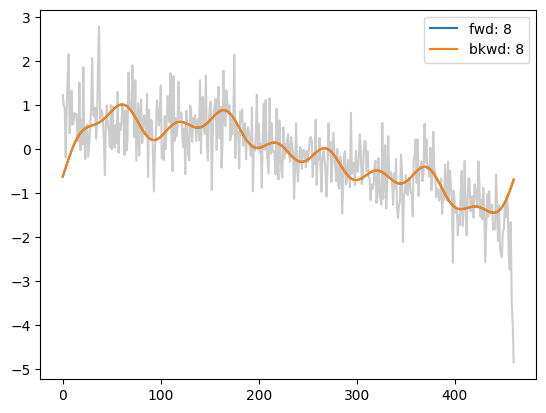

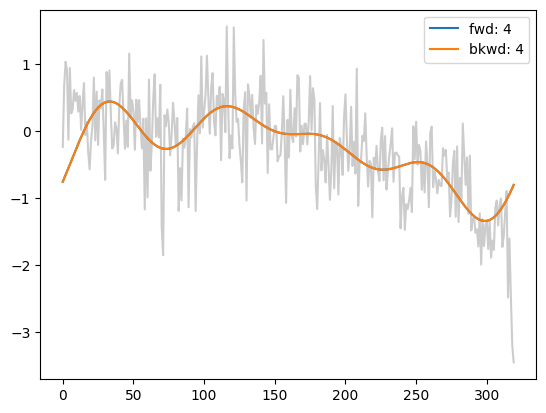

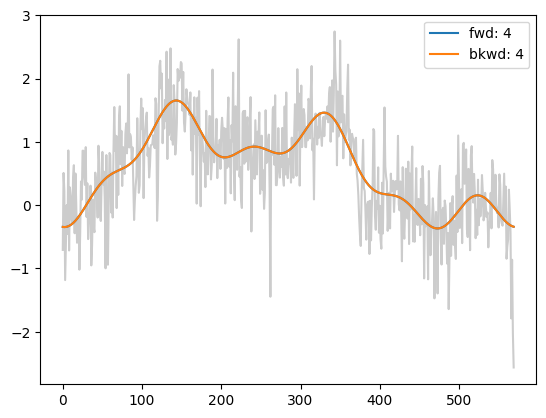

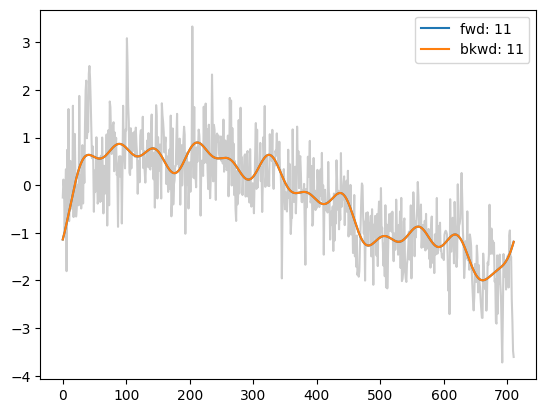

In [10]:
plts = []
fwd_yr_lens_array = []
bkwd_yr_lens_array = []
for i in range(len(elt_array)):
    elt = np.asarray(elt_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        elt, bandwidth, mode, threshold, criterion, prior
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        elt, bandwidth, "backward", threshold, criterion, prior
    )

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

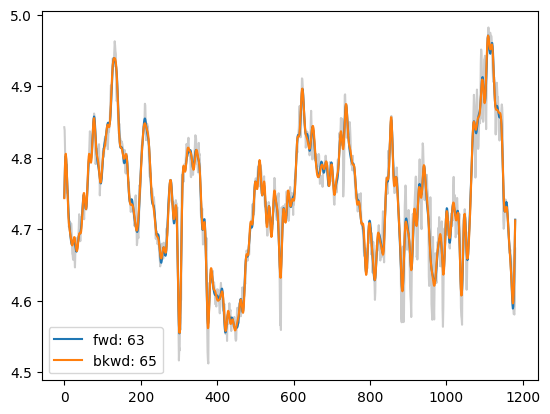

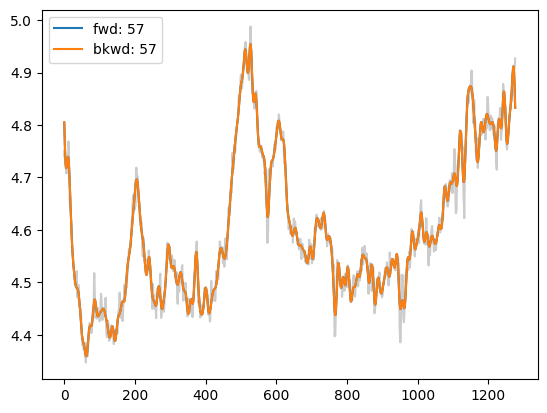

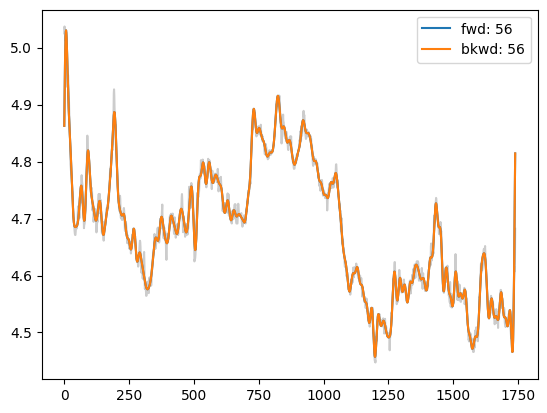

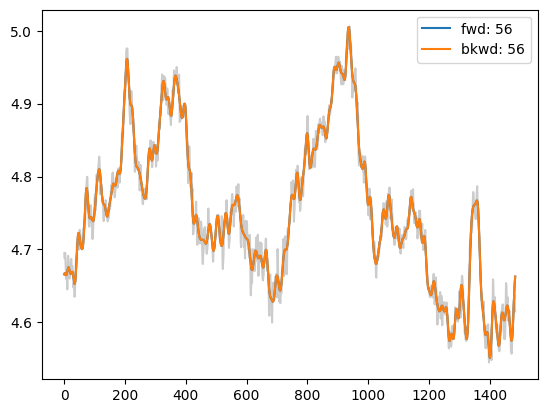

In [11]:
grey_array = [
    grey_values[grey_values['case']==i]['cleaned_grey'] for i in [43,44,55,56]
]
plts = []
for i in range(len(grey_array)):
    grey_val = np.asarray(grey_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "forward",
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "backward",
    )

    p = plt.figure()
    p = plt.plot(range(len(grey_val)), grey_val, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

In [12]:
(elt_array[0])

0      1.231484
1      0.979279
2      0.941318
3     -0.189878
4      0.958900
         ...   
456   -2.739936
457   -1.660968
458   -3.467318
459   -3.959522
460   -4.853588
Name: Sr88_ppm, Length: 461, dtype: float64

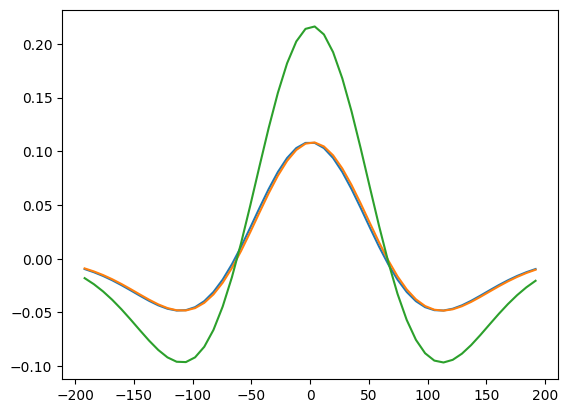

In [13]:
max_age = 40

scale = 64
x = np.linspace(-3*scale,3*scale)
y1 = bpdn._ricker_wavelet(x, scale, 0)
y2 = bpdn._ricker_wavelet(x, scale, 1.8)
y = bpdn._ricker_wavelet(x, scale, 0) + bpdn._ricker_wavelet(x, scale, 3.6)

plt.figure()
plt.plot(x, y1, label=f"Ricker ${scale} {0}")
plt.plot(x, y2, label=f"Ricker ${scale} {3.6}")
plt.plot(x, y, label=f"Ricker ${scale} +")
plt.show()


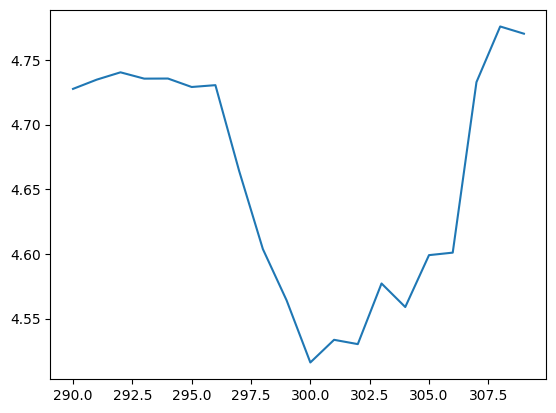

12

In [14]:
plt.figure()
plt.plot(grey_array[0][290:310])
plt.show()
308-296

In [150]:
def lin_interp(a,b,t):
    return a + (b-a)*t

def detect_seg(x1,y1,x2,y2,cwtmatr,ts):
    ystep = 1 - 2*(y1>y2)
    segx=np.arange(x1, x2).round() # segment x coordinate             
    segy=np.arange(y1, y2, step=ystep).round() # segment y coordinate
    if len(segx)>len(segy): # interpolate y to the same length as x
        t = np.linspace(0, 1, len(segx))
        segy = lin_interp(y1, y2, t)
        segy = np.array(segy).round()
    elif len(segx)<len(segy): # interpolate x to the same length as y
        t = np.linspace(0, 1, len(segy))
        segx = lin_interp(x1, x2, t)
        segx = np.array(segx).round()
    # DRAW BAND COUNT MARKS
    ts_wl=cwtmatr[np.array(segy).astype('int'),np.array(segx).astype('int')] # obtain time-series from wavelet
    x=np.copy(segx)
    # average of the time-series for threshold
    ts_ma=np.array([np.nanmean(ts_wl)]*np.shape(ts_wl)[0])        
    sw=0 # band switch
    nb_tmp=0 # band counter
    # cts=np.empty_like(x)*np.nan # count time series
    #    cts_w=np.copy(cts)
    # ctsy=np.nanmin(ts)+(np.nanmax(ts)-np.nanmin(ts))/10*k[0]# y value for cts
    for j in range(len(ts_wl)):
        if ts_wl[j]>ts_ma[j] and sw==0:
            sw=1
            b_st=j # band start
            nb_tmp=nb_tmp+1
        elif ts_wl[j]<ts_ma[j] and sw==1:
            sw=0
            # cts[round(b_st+(j-b_st)/2)]=ctsy # time series to display
    return nb_tmp

In [151]:
def detect_path(xs,ys,cwtmatr,ts):
    linex = []
    liney = []
    for i in range(len(xs)-1):
        x1 = xs[i]
        x2 = xs[i+1]
        y1 = ys[i]
        y2 = ys[i+1]
        ystep = 1 - 2*(y1>y2)
        if i+1 < len(xs)-1: # exclude end point as it is included in next segment
            segx=np.arange(x1, x2).round() # segment x coordinate             
            segy=np.arange(y1, y2, step=ystep).round() # segment y coordinate
        else: # include end point
            segx=np.arange(x1, x2+1).round() # segment x coordinate             
            segy=np.arange(y1, y2+1, step=ystep).round() # segment y coordinate
        if len(segx)>len(segy): # interpolate y to the same length as x
            t = np.linspace(0, 1, len(segx)+1, endpoint=True)[:-1]
            segy = lin_interp(y1, y2, t)
            segy = np.array(segy).round()
        elif len(segx)<len(segy): # interpolate x to the same length as y
            t = np.linspace(0, 1, len(segy)+1, endpoint=True)[:-1]
            segx = lin_interp(x1, x2, t)
            segx = np.array(segx).round()
        linex.append(segx)
        liney.append(segy)
    linex = np.concatenate(linex)
    liney = np.concatenate(liney)
    # DRAW BAND COUNT MARKS
    ts_wl=cwtmatr[np.array(liney).astype('int'),np.array(linex).astype('int')] # obtain time-series from wavelet
    x=np.copy(linex)
    # average of the time-series for threshold
    ts_ma=np.array([np.nanmean(ts_wl)]*np.shape(ts_wl)[0])        
    sw=0 # band switch
    nb_tmp=0 # band counter
    # cts=np.empty_like(x)*np.nan # count time series
    #    cts_w=np.copy(cts)
    # ctsy=np.nanmin(ts)+(np.nanmax(ts)-np.nanmin(ts))/10*k[0]# y value for cts
    for j in range(len(ts_wl)):
        if ts_wl[j]>ts_ma[j] and sw==0:
            sw=1
            b_st=j # band start
            nb_tmp=nb_tmp+1
        elif ts_wl[j]<ts_ma[j] and sw==1:
            sw=0
            # cts[round(b_st+(j-b_st)/2)]=ctsy # time series to display
    return nb_tmp

[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589. -588. ...  588.  589.  590.]
1181
1181
[-590. -589.

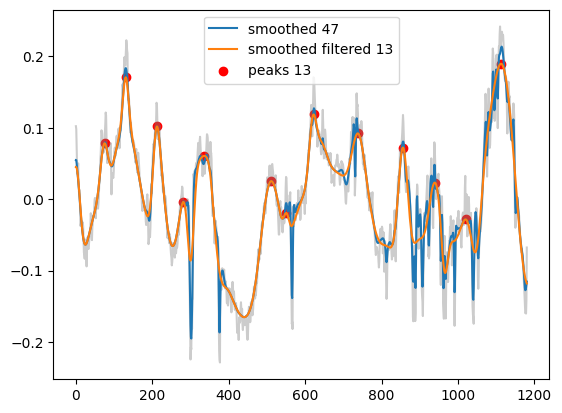

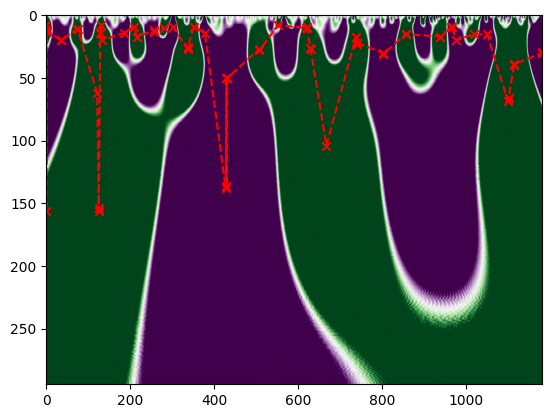

47
15


In [ ]:
plts = []
coefs = []
sparseness = [1,1,1,1]
for i in range(len(grey_array)):
    elt = np.asarray(grey_array[i], dtype=np.float64)
    elt -= np.mean(elt)
    scale_switch = 50
    scales1 = np.arange(1, max(2, min(len(elt) // 4 + 1, scale_switch + 1)), step=sparseness[i])
    scales2 = np.arange(max(2, min(len(elt) // 4 + 1, scale_switch + 1)), max(2, len(elt) // 4 + 1), step=sparseness[i]+1)
    scales = np.concatenate((
        scales1, # bpdn.fractional_dyadic_grid(len(elt), 0.25)
        scales2, # bpdn.fractional_dyadic_grid(len(elt), 0.25)
    ))
    shifts = np.concatenate((
        np.ones(len(scales1)), # bpdn.fractional_dyadic_grid(len(elt), 0.25)
        2*np.ones(len(scales2)), # bpdn.fractional_dyadic_grid(len(elt), 0.25)
    )) # np.ones(len(scales)) # bpdn.fractional_dyadic_grid(len(elt), 0.25)#np.ones(len(scales))
    dictionary = bpdn.ricker_cwt_dictionary(len(elt), scales, shifts, dtype=np.float64)
    dictionary_cpy = dictionary.copy()

    # dictionary terms with scale=n are 'mounds' with approx 3.6n points.
    # Mounds which are too short can be filtered out to help smooth the signal.
    min_pts_per_year = len(elt)/max_age
    print(f"min_pts_per_year: {min_pts_per_year}")
    expanded_scales = bpdn.expand_scales(len(elt), scales, shifts)
    pts_per_mound = 3.6*expanded_scales
    # plt.figure()
    # plt.plot(pts_per_mound)
    # plt.ylim((0,100))
    # plt.show()
    low_freq_scales_ix = pts_per_mound > (min_pts_per_year)

    def peak_prior(coef, X=dictionary_cpy, low_freq_ix=low_freq_scales_ix):
        low_freq_coef = coef * low_freq_ix[:, np.newaxis]
        smoothed = np.dot(X, low_freq_coef)
        prior_pdf = np.zeros(smoothed.shape[1])
        for model_ix in range(smoothed.shape[1]):
            peaks = filt.find_peaks(smoothed[:,model_ix])
            age = len(peaks)
            prior_pdf[model_ix] = truncated_geometric_pdf(mortality_rate, age)
        return prior_pdf

    coef, smoothed = bpdn.basis_pursuit_denoising(elt, dictionary, peak_prior, copy_dictionary=True)
    smoothed = np.dot(dictionary_cpy, coef)

    low_freq_coef = coef * low_freq_scales_ix
    low_freq_smoothed = np.dot(dictionary_cpy, low_freq_coef)
    
    p = plt.figure()
    p = plt.plot(elt, color="grey", alpha=0.4)
    n_peaks_smoothed = len(filt.find_peaks(smoothed))
    p = plt.plot(smoothed, label=f"smoothed {n_peaks_smoothed}")
    peak_locations = filt.find_peaks(low_freq_smoothed)
    n_peaks = len(peak_locations)
    p = plt.plot(low_freq_smoothed, label=f"smoothed filtered {n_peaks}")
    p = plt.scatter(peak_locations, low_freq_smoothed[peak_locations], label=f"peaks {n_peaks}", color="red")
    p = plt.legend()
    plt.show()
    
    # print(np.count_nonzero(coef))
    # plts.append(p)
    # plt.figure()
    # plt.plot(coef, label="Coefs")
    # plt.show()
    # coefs.append(coef)

    cwt, freqs = pywt.cwt(elt, np.arange(1,len(elt)//4+1), 'mexh')

    tmin = -len(elt)//2 + (len(elt)%2)/2
    tmax = len(elt)//2 + (len(elt)%2)/2
    expanded_shifts = []
    for (i, scale) in enumerate(scales):
        delta = shifts[i]
        centers = np.arange(tmin+delta/2, tmax, step=delta, dtype=float)
        expanded_shifts.append(centers)
    expanded_shifts = np.concatenate(expanded_shifts)

    non_zero_coef_idx = np.abs(low_freq_coef) > np.finfo(low_freq_coef.dtype).eps

    plt.figure()
    wlb=np.quantile(cwt,0.1)/10
    wub=np.quantile(cwt,0.9)/10
    plt.imshow(cwt, cmap='PRGn', aspect='auto',
            vmax=-wlb, vmin=wlb)
    x = np.zeros(np.sum(non_zero_coef_idx)+2)
    y = np.zeros(np.sum(non_zero_coef_idx)+2)
    x[1:-1] = expanded_shifts[non_zero_coef_idx]-tmin
    y[1:-1] = expanded_scales[non_zero_coef_idx]-1
    x[0] = 0
    x[-1] = 0
    y[0] = y[1]
    y[-1] = y[-2]
    sixd = np.argsort(x)
    x = x[sixd]
    y = y[sixd]
    plt.scatter(x,y, marker='x', color='red')
    plt.plot(x,y, color='red', linestyle='dashed')
    plt.show()

    wlcount = 0 
    for i in range(len(x)-1):
        wlcount += detect_seg(x[i], y[i], x[i+1], y[i+1], cwt, elt)
    print(wlcount)

    wlcount2 = 0 
    wlcount2 += detect_path(x,y, cwt, elt)
    print(wlcount2)

    




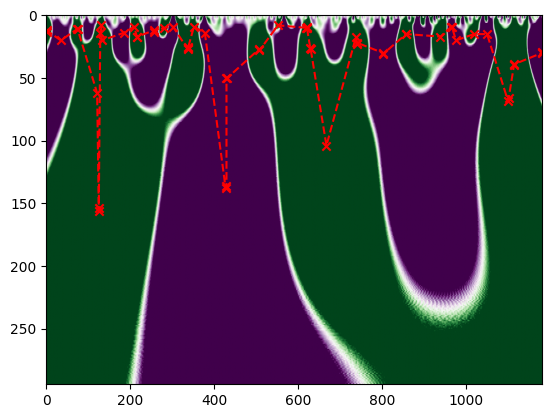

In [85]:
cwt, freqs = pywt.cwt(elt, np.arange(1,len(elt)//4+1), 'mexh')

tmin = -len(elt)//2 + (len(elt)%2)/2
tmax = len(elt)//2 + (len(elt)%2)/2
expanded_shifts = []
for (i, scale) in enumerate(scales):
    delta = shifts[i]
    centers = np.arange(tmin+delta/2, tmax, step=delta, dtype=float)
    expanded_shifts.append(centers)
expanded_shifts = np.concatenate(expanded_shifts)

non_zero_coef_idx = np.abs(low_freq_coef) > np.finfo(low_freq_coef.dtype).eps

plt.figure()
wlb=np.quantile(cwt,0.1)/10
wub=np.quantile(cwt,0.9)/10
plt.imshow(cwt, cmap='PRGn', aspect='auto',
        vmax=-wlb, vmin=wlb)
x = expanded_shifts[non_zero_coef_idx]-tmin
y = expanded_scales[non_zero_coef_idx]-1
sixd = np.argsort(x)
x = x[sixd]
y = y[sixd]
plt.scatter(x,y, marker='x', color='red')
plt.plot(x,y, color='red', linestyle='dashed')
plt.show()

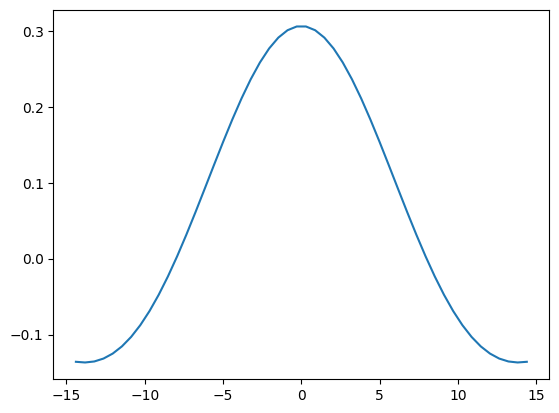

In [22]:
scale = expanded_scales[low_freq_scales_ix][0]-1
x = np.linspace(-1.8*scale, 1.8*scale)
y = bpdn._ricker_wavelet(x, scale, 0)
plt.figure()
plt.plot(x, y, label=f"Ricker with scale {scale}")
plt.show()

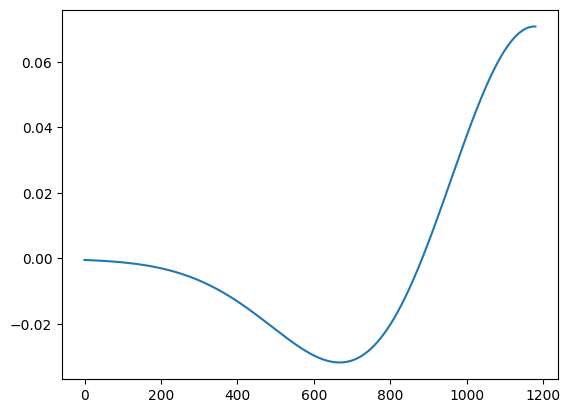

In [23]:
plt.figure()
plt.plot(dictionary[:,-1])
plt.show()

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  55  57
  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93
  95  97  99 101 103 105 107 109 111 113 115]
[-230. -229. -228. -227. -226. -225. -224. -223. -222. -221. -220. -219.
 -218. -217. -216. -215. -214. -213. -212. -211. -210. -209. -208. -207.
 -206. -205. -204. -203. -202. -201. -200. -199. -198. -197. -196. -195.
 -194. -193. -192. -191. -190. -189. -188. -187. -186. -185. -184. -183.
 -182. -181. -180. -179. -178. -177. -176. -175. -174. -173. -172. -171.
 -170. -169. -168. -167. -166. -165. -164. -163. -162. -161. -160. -159.
 -158. -157. -156. -155. -154. -153. -152. -151. -150. -149. -148. -147.
 -146. -145. -144. -143. -142. -141. -140. -139. -138. -137. -136. -135.
 -134. -133. -132. -131. -130. -129. -128. -127. -126. -125. -124. -123.
 -122

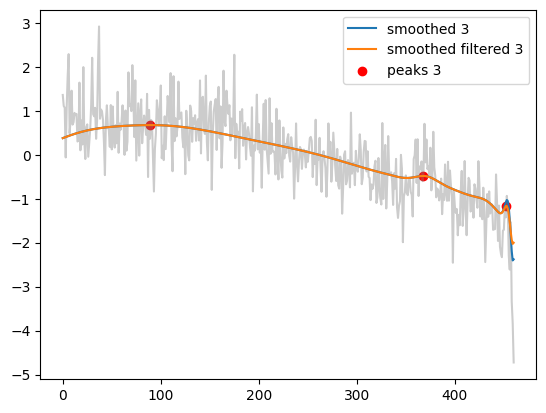

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79]
[-159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
  -49.5  -48.5  -47.

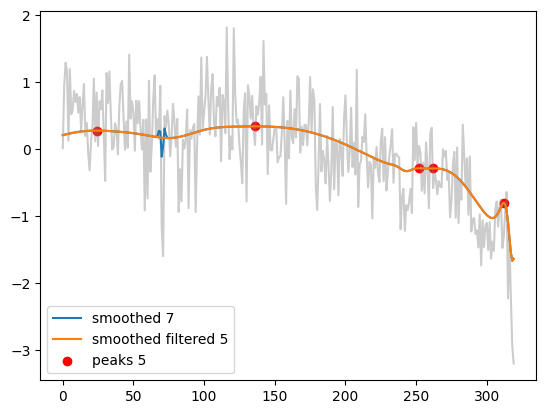

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  55  57
  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93
  95  97  99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 129
 131 133 135 137 139 141]
[-284.5 -283.5 -282.5 -281.5 -280.5 -279.5 -278.5 -277.5 -276.5 -275.5
 -274.5 -273.5 -272.5 -271.5 -270.5 -269.5 -268.5 -267.5 -266.5 -265.5
 -264.5 -263.5 -262.5 -261.5 -260.5 -259.5 -258.5 -257.5 -256.5 -255.5
 -254.5 -253.5 -252.5 -251.5 -250.5 -249.5 -248.5 -247.5 -246.5 -245.5
 -244.5 -243.5 -242.5 -241.5 -240.5 -239.5 -238.5 -237.5 -236.5 -235.5
 -234.5 -233.5 -232.5 -231.5 -230.5 -229.5 -228.5 -227.5 -226.5 -225.5
 -224.5 -223.5 -222.5 -221.5 -220.5 -219.5 -218.5 -217.5 -216.5 -215.5
 -214.5 -213.5 -212.5 -211.5 -210.5 -209.5 -208.5 -207.5 -206.5 -205.5
 -204.5 -203.5 -202.5 -201.5 -200.5 -199.

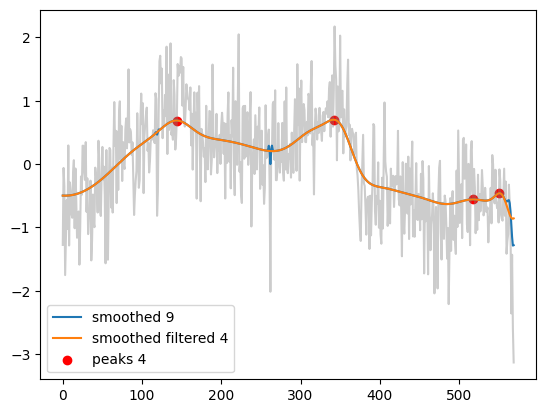

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  55  57
  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93
  95  97  99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 129
 131 133 135 137 139 141 143 145 147 149 151 153 155 157 159 161 163 165
 167 169 171 173 175 177]
[-355. -354. -353. -352. -351. -350. -349. -348. -347. -346. -345. -344.
 -343. -342. -341. -340. -339. -338. -337. -336. -335. -334. -333. -332.
 -331. -330. -329. -328. -327. -326. -325. -324. -323. -322. -321. -320.
 -319. -318. -317. -316. -315. -314. -313. -312. -311. -310. -309. -308.
 -307. -306. -305. -304. -303. -302. -301. -300. -299. -298. -297. -296.
 -295. -294. -293. -292. -291. -290. -289. -288. -287. -286. -285. -284.
 -283. -282. -281. -280. -279. -278. -277. -276. -275. -274. -273. -272.
 -271. -270. -269. -268. 

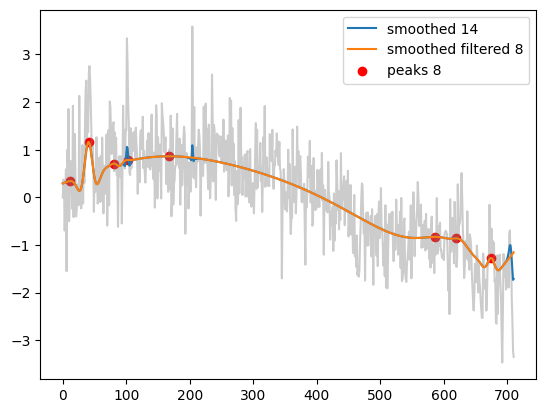

In [24]:

plts = []
coefs = []
sparseness = [1,1,1,1]
for i in range(len(elt_array)):
    elt = np.asarray(elt_array[i], dtype=np.float64)
    elt -= np.mean(elt)
    scale_switch = 50
    scales1 = np.arange(1, max(2, min(len(elt) // 4 + 1, scale_switch + 1)), step=sparseness[i])
    scales2 = np.arange(max(2, min(len(elt) // 4 + 1, scale_switch + 1)), max(2, len(elt) // 4 + 1), step=sparseness[i]+1)
    scales = np.concatenate((
        scales1, # bpdn.fractional_dyadic_grid(len(elt), 0.25)
        scales2, # bpdn.fractional_dyadic_grid(len(elt), 0.25)
    ))
    print(scales)
    shifts = np.concatenate((
        np.ones(len(scales1)), # bpdn.fractional_dyadic_grid(len(elt), 0.25)
        2*np.ones(len(scales2)), # bpdn.fractional_dyadic_grid(len(elt), 0.25)
    )) # np.ones(len(scales)) # bpdn.fractional_dyadic_grid(len(elt), 0.25)#np.ones(len(scales))
    dictionary = bpdn.ricker_cwt_dictionary(len(elt), scales, shifts, dtype=np.float64)
    dictionary_cpy = dictionary.copy()

    # dictionary terms with scale=n are 'mounds' with approx 3.6n points.
    # Mounds which are too short can be filtered out to help smooth the signal.
    min_pts_per_year = len(elt)/max_age
    print(f"min_pts_per_year: {min_pts_per_year}")
    expanded_scales = bpdn.expand_scales(len(elt), scales, shifts)
    pts_per_mound = 3.6*expanded_scales
    # plt.figure()
    # plt.plot(pts_per_mound)
    # plt.ylim((0,100))
    # plt.show()
    low_freq_scales_ix = pts_per_mound > (min_pts_per_year)

    def peak_prior(coef, X=dictionary_cpy, low_freq_ix=low_freq_scales_ix):
        low_freq_coef = coef * low_freq_ix[:, np.newaxis]
        smoothed = np.dot(X, low_freq_coef)
        prior_pdf = np.zeros(smoothed.shape[1])
        for model_ix in range(smoothed.shape[1]):
            peaks = filt.find_peaks(smoothed[:,model_ix])
            age = len(peaks)
            prior_pdf[model_ix] = truncated_geometric_pdf(mortality_rate, age)
        return prior_pdf

    coef, smoothed = bpdn.basis_pursuit_denoising(elt, dictionary, peak_prior, copy_dictionary=True)
    smoothed = np.dot(dictionary_cpy, coef)

    low_freq_coef = coef * low_freq_scales_ix
    low_freq_smoothed = np.dot(dictionary_cpy, low_freq_coef)
    
    p = plt.figure()
    p = plt.plot(elt, color="grey", alpha=0.4)
    n_peaks_smoothed = len(filt.find_peaks(smoothed))
    p = plt.plot(smoothed, label=f"smoothed {n_peaks_smoothed}")
    peak_locations = filt.find_peaks(low_freq_smoothed)
    n_peaks = len(peak_locations)
    p = plt.plot(low_freq_smoothed, label=f"smoothed filtered {n_peaks}")
    p = plt.scatter(peak_locations, low_freq_smoothed[peak_locations], label=f"peaks {n_peaks}", color="red")
    p = plt.legend()
    plt.show()
    
    # print(np.count_nonzero(coef))
    # plts.append(p)
    # plt.figure()
    # plt.plot(coef, label="Coefs")
    # plt.show()
    # coefs.append(coef)




<Figure size 640x480 with 0 Axes>

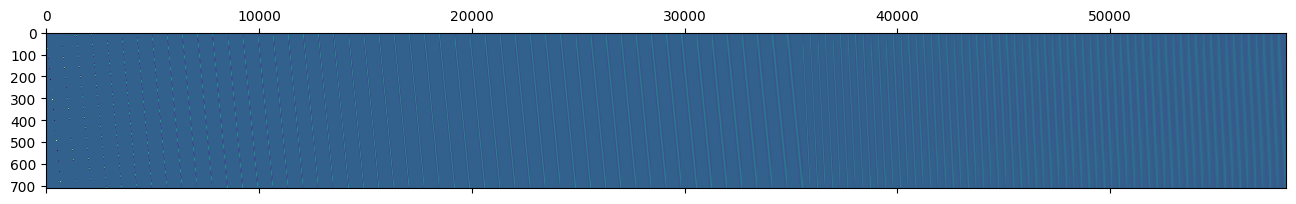

In [25]:
plt.figure()
plt.matshow(dictionary, aspect='auto', cmap='viridis')
plt.show()